# Predict Test

In [1]:
import time
import pymysql
import pandas as pd
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from scipy.stats import pearsonr
import torch.nn as nn

from sklearn.metrics import mean_squared_error

### Load data

In [2]:
conn = pymysql.connect(host='localhost', port=3306, user='root', password='pw', db='data_test', charset='utf8')
cur = conn.cursor()

In [3]:
sensor_data = pd.read_sql("select * from sensor_data", conn)
sensor_data

,data_id,created_at,input_data,ss_id,pos_name,type_name
0,221234,2022-10-11 14:04:55,3038.0,9,HR,TVOC
1,221227,2022-10-11 14:04:55,487.0,2,HR,CO2
2,221233,2022-10-11 14:04:55,10.0,8,HR,PM10
3,221228,2022-10-11 14:04:55,19.4,3,HR,온도
4,221231,2022-10-11 14:04:55,10.0,6,HR,PM2.5
...,...,...,...,...,...,...
155670,65363,2022-04-30 23:55:49,10.0,7,HR,PM4.0
155671,65365,2022-04-30 23:55:49,812.0,9,HR,TVOC
155672,65364,2022-04-30 23:55:49,10.0,8,HR,PM10
155673,65361,2022-04-30 23:55:49,10.0,5,HR,PM1.0


In [4]:
## HR
# 이산화탄소 센서
co2_data = sensor_data.loc[sensor_data['ss_id']==2]
# 온도 센서
temp_data = sensor_data.loc[sensor_data['ss_id']==3]
# 습도 센서
humid_data = sensor_data.loc[sensor_data['ss_id']==4]
# PM1.0 센서
pm1_data = sensor_data.loc[sensor_data['ss_id']==5]
# PM2.5 센서
pm2_data = sensor_data.loc[sensor_data['ss_id']==6]
# PM4.0 센서
pm4_data = sensor_data.loc[sensor_data['ss_id']==7]
# PM10 센서
pm10_data = sensor_data.loc[sensor_data['ss_id']==8]
# TVOC 센서
tvoc_data = sensor_data.loc[sensor_data['ss_id']==9]
col_list = list(co2_data.columns)
col_list[2] = 'co2_data'
co2_data.columns = col_list
col_list = list(temp_data.columns)
col_list[2] = 'temp_data'
temp_data.columns = col_list
col_list = list(humid_data.columns)
col_list[2] = 'humid_data'
humid_data.columns = col_list
col_list = list(pm1_data.columns)
col_list[2] = 'pm1_data'
pm1_data.columns = col_list
col_list = list(pm2_data.columns)
col_list[2] = 'pm2_data'
pm2_data.columns = col_list
col_list = list(pm4_data.columns)
col_list[2] = 'pm4_data'
pm4_data.columns = col_list
col_list = list(pm10_data.columns)
col_list[2] = 'pm10_data'
pm10_data.columns = col_list
col_list = list(tvoc_data.columns)
col_list[2] = 'tvoc_data'
tvoc_data.columns = col_list

In [5]:
hr_sensor_data = pd.merge(left=co2_data, right=temp_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=humid_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=pm1_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=pm2_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=pm4_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=pm10_data, how="inner", on="created_at")
hr_sensor_data = pd.merge(left=hr_sensor_data, right=tvoc_data, how="inner", on="created_at")

hr_sensor_data = hr_sensor_data[["created_at","co2_data","temp_data","humid_data","pm1_data","pm2_data","pm4_data","pm10_data","tvoc_data"]]
hr_sensor_data = hr_sensor_data.sort_values(by=['created_at'],ascending=True)

/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'data_id_x', 'pos_name_x', 'ss_id_x', 'type_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'data_id_x', 'pos_name_x', 'ss_id_x', 'type_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  """
/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'data_id_x', 'pos_name_x', 'ss_id_x', 'type_name_x'} in the result is deprecated and will raise a

In [21]:
hr_sensor_data_value = hr_sensor_data[["pm1_data","pm2_data","pm4_data","pm10_data"]]
hr_sensor_data.index=hr_sensor_data["created_at"]
hr_sensor_data_value

,pm1_data,pm2_data,pm4_data,pm10_data
created_at,,,,
2022-05-01 00:05:49,10.0,10.0,10.0,10.0
2022-05-01 00:15:49,9.0,9.0,9.0,9.0
2022-05-01 00:25:49,9.0,9.0,9.0,9.0
2022-05-01 00:35:49,9.0,9.0,9.0,9.0
2022-05-01 00:45:49,9.0,9.0,9.0,9.0
...,...,...,...,...
2022-10-11 13:24:55,11.0,11.0,11.0,11.0
2022-10-11 13:34:55,11.0,11.0,11.0,11.0
2022-10-11 13:44:55,11.0,11.0,11.0,11.0


<AxesSubplot:xlabel='created_at'>

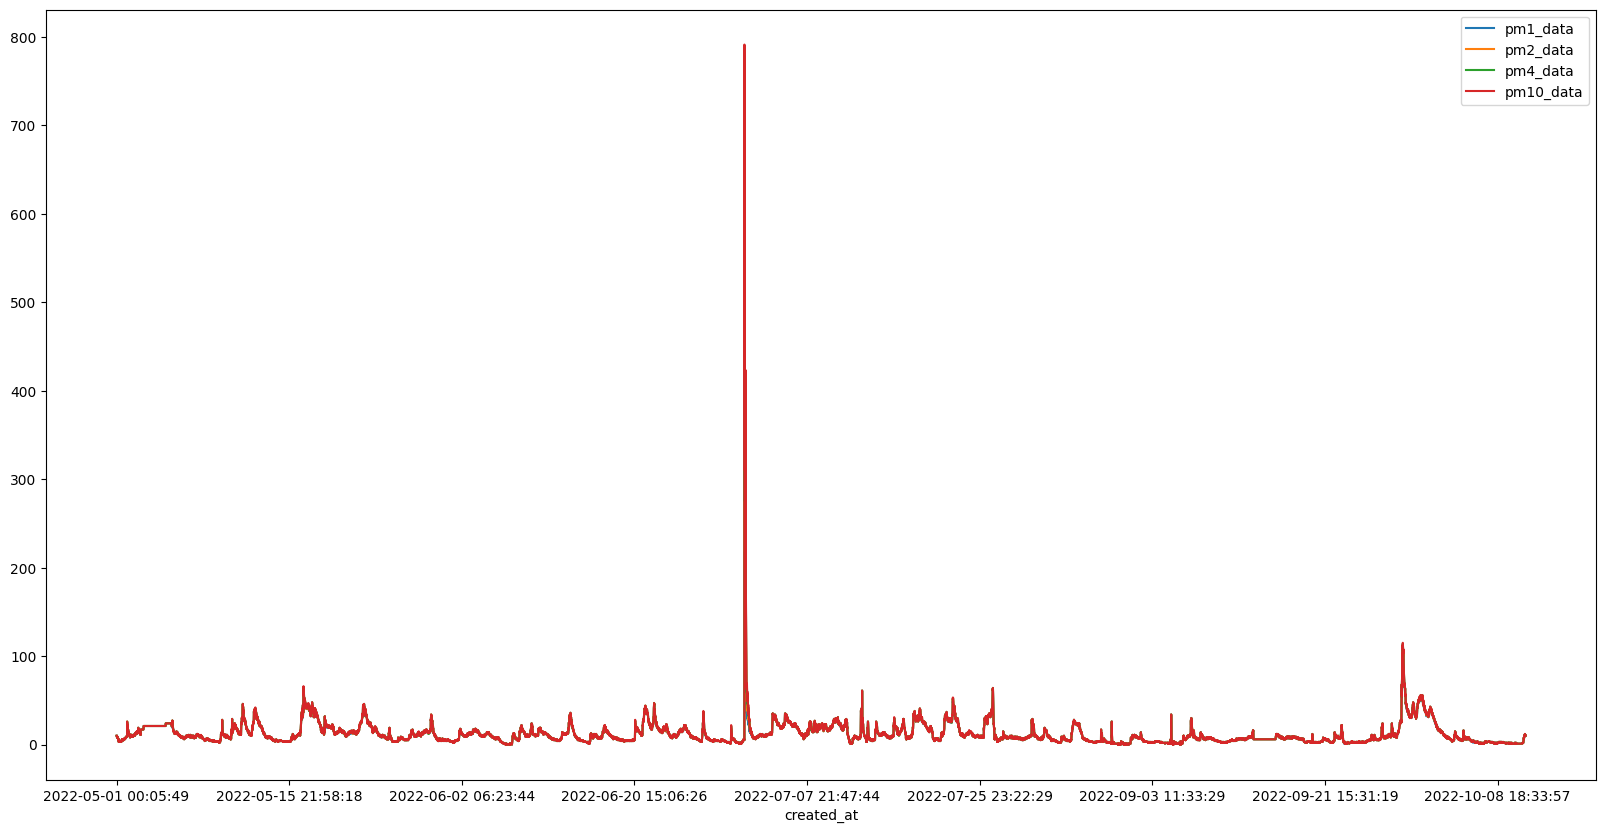

In [22]:
hr_sensor_data_value.plot(figsize=(20,10))

## Before Denoising

### Pearson correlation

In [10]:
print("pm 1.0 & pm 2.5: {}".format(pearsonr(hr_sensor_data_value['pm1_data'],hr_sensor_data_value['pm2_data'])[0]))
print("pm 1.0 & pm 4.0: {}".format(pearsonr(hr_sensor_data_value['pm1_data'],hr_sensor_data_value['pm4_data'])[0]))
print("pm 1.0 & pm 10.0: {}".format(pearsonr(hr_sensor_data_value['pm1_data'],hr_sensor_data_value['pm10_data'])[0]))
print("pm 2.5 & pm 4.0: {}".format(pearsonr(hr_sensor_data_value['pm2_data'],hr_sensor_data_value['pm4_data'])[0]))
print("pm 2.5 & pm 10.0: {}".format(pearsonr(hr_sensor_data_value['pm2_data'],hr_sensor_data_value['pm10_data'])[0]))
print("pm 4.0 & pm 10.0: {}".format(pearsonr(hr_sensor_data_value['pm4_data'],hr_sensor_data_value['pm10_data'])[0]))



pm 1.0 & pm 2.5: 0.9571808979179246
pm 1.0 & pm 4.0: 0.8962647347190706
pm 1.0 & pm 10.0: 0.8681765427560577
pm 2.5 & pm 4.0: 0.9861987266530718
pm 2.5 & pm 10.0: 0.974558000268986
pm 4.0 & pm 10.0: 0.9981813828562845


In [13]:
hr_sensor_data_value_denoised = hr_sensor_data_value

In [14]:
com = 50

<AxesSubplot:xlabel='created_at'>

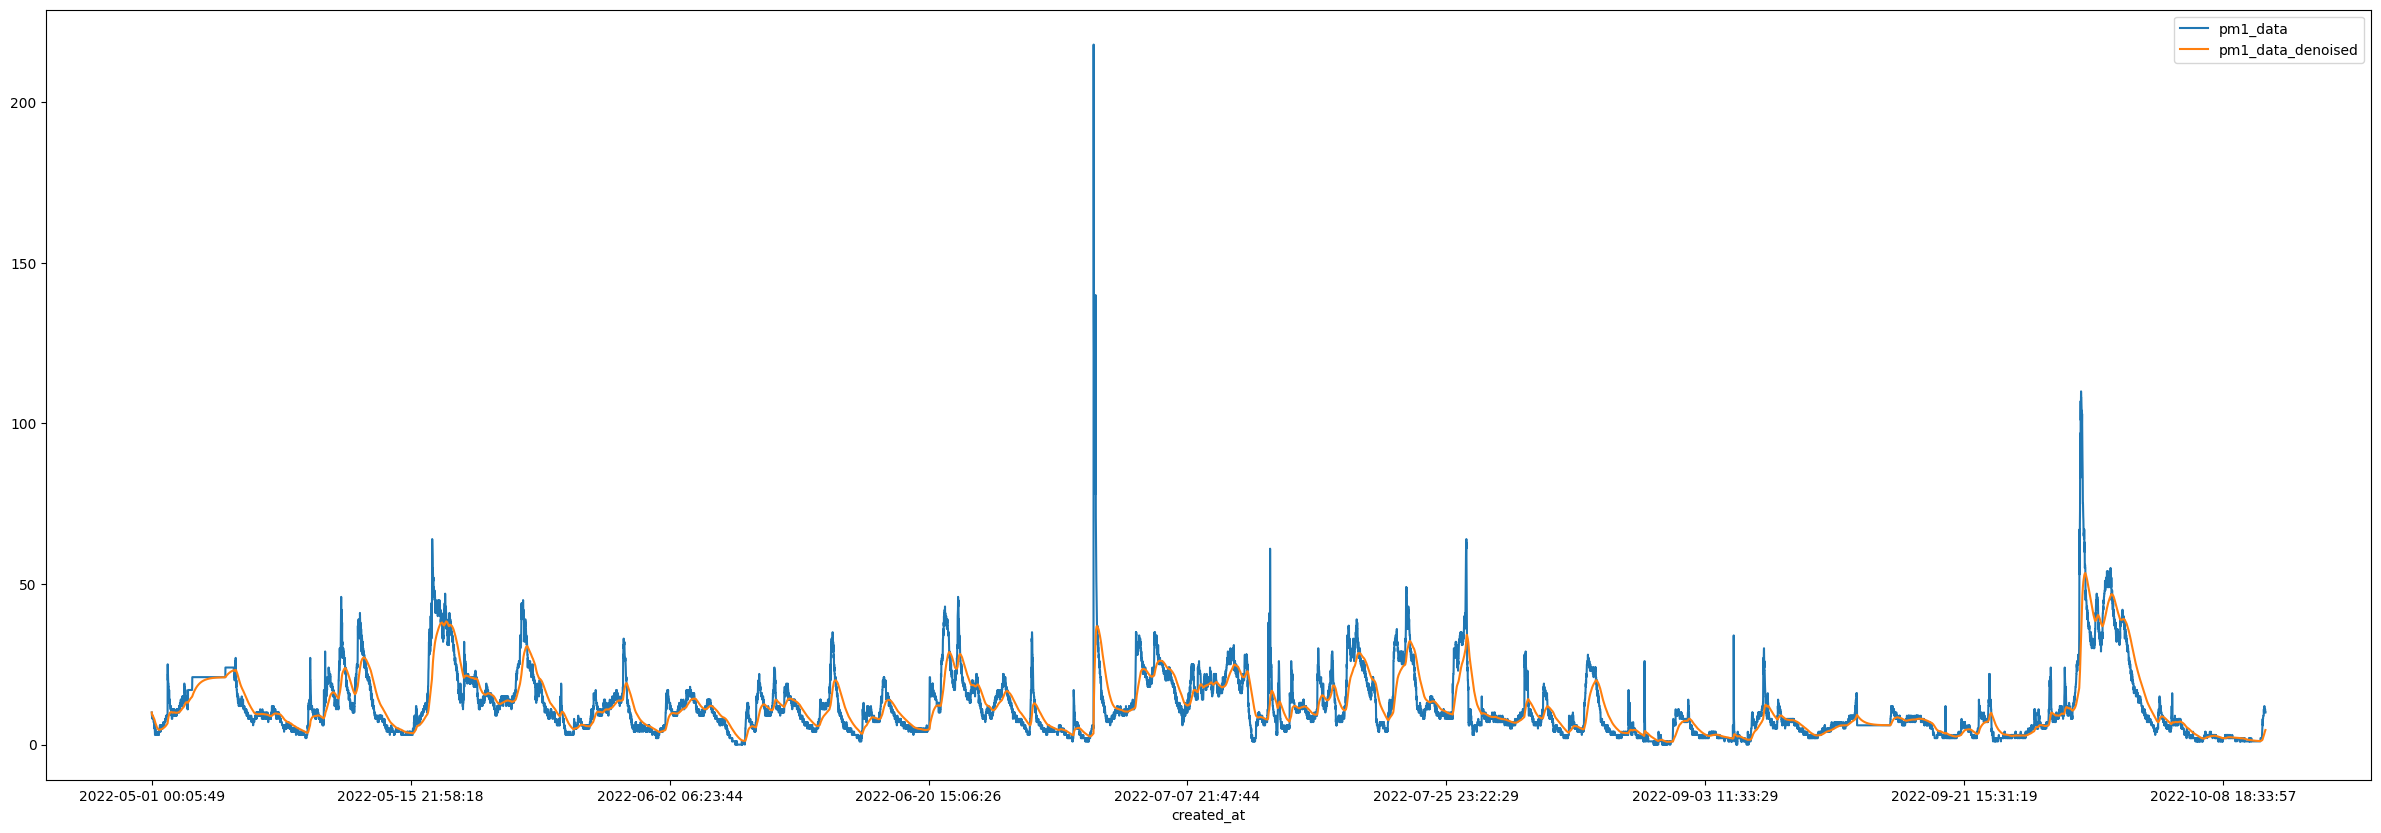

In [15]:
# pm 1.0 data
ema = pd.DataFrame(hr_sensor_data_value['pm1_data']).ewm(com).mean()
hr_sensor_data_value_denoised['pm1_data_denoised'] = ema['pm1_data']
hr_sensor_data_value_denoised.plot(y=['pm1_data', 'pm1_data_denoised'], figsize=(30,10))


<AxesSubplot:xlabel='created_at'>

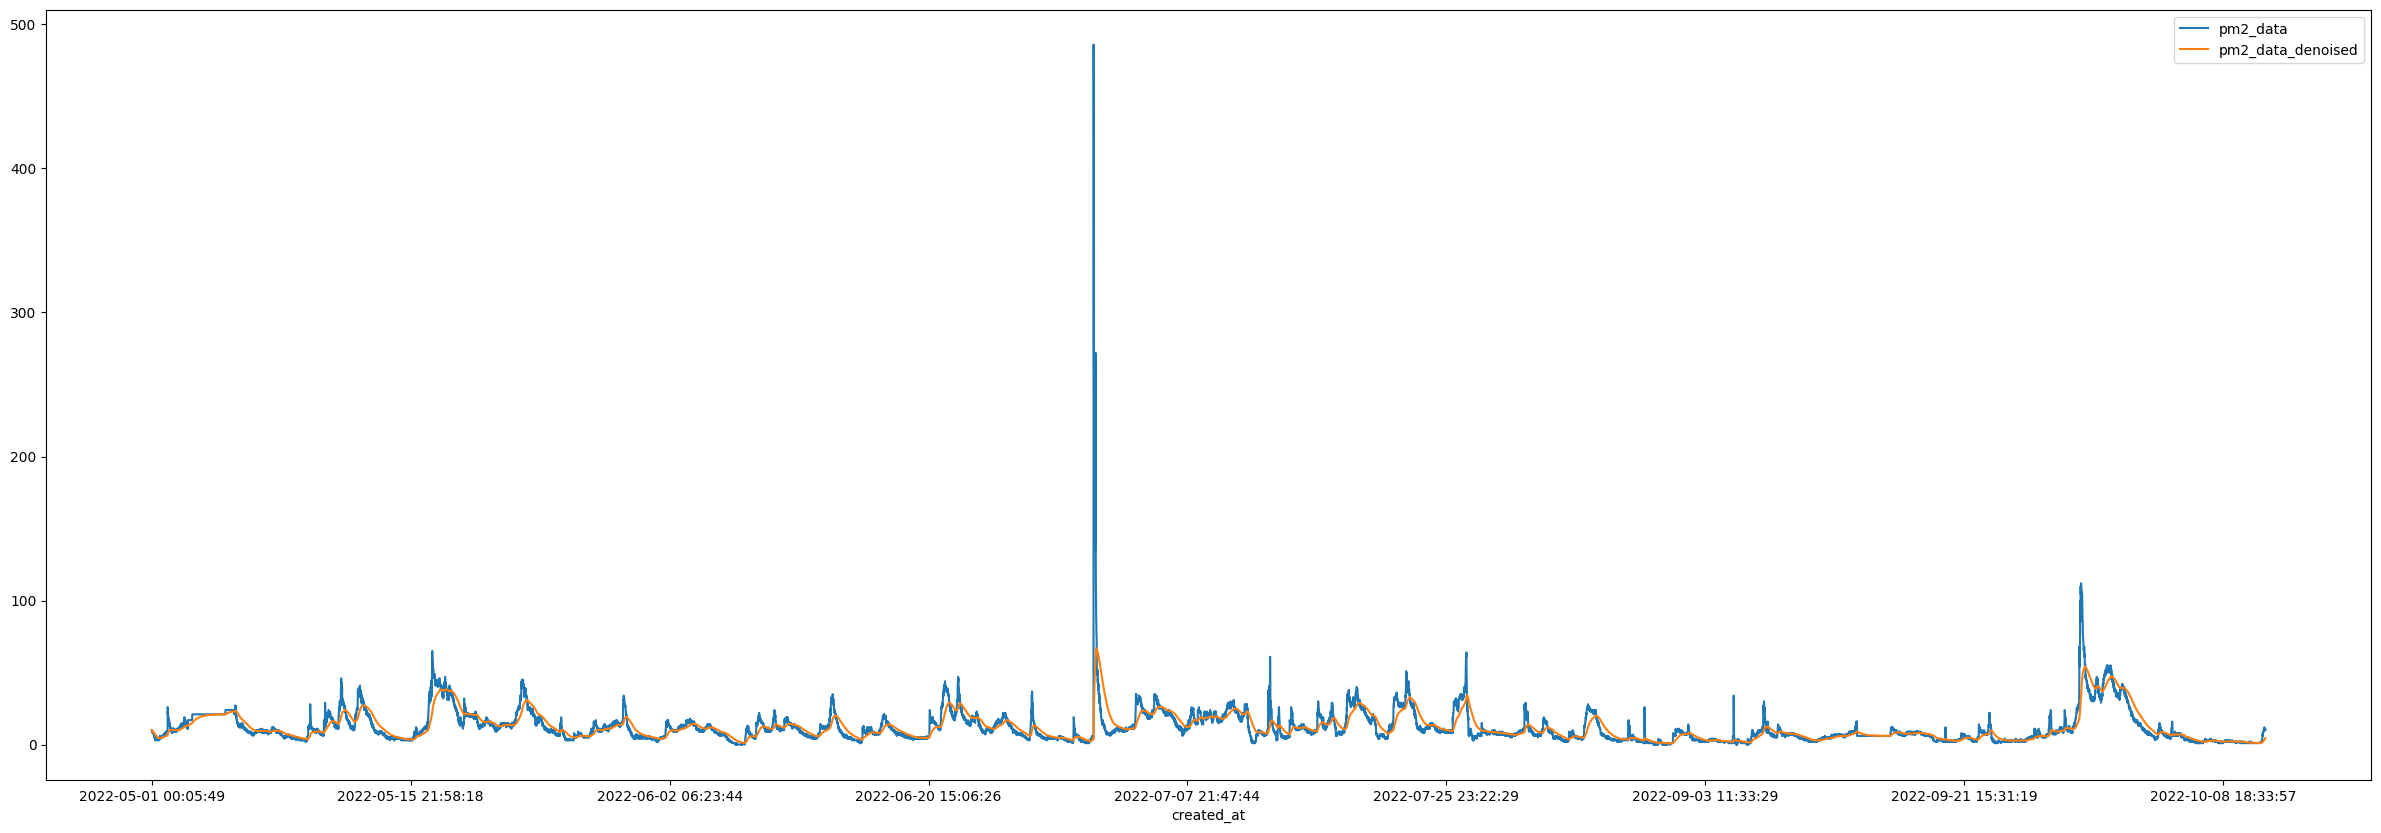

In [16]:
# pm 2.5 data
ema = pd.DataFrame(hr_sensor_data_value['pm2_data']).ewm(com).mean()
hr_sensor_data_value_denoised['pm2_data_denoised'] = ema['pm2_data']
hr_sensor_data_value_denoised.plot(y=['pm2_data', 'pm2_data_denoised'], figsize=(30,10))


<AxesSubplot:xlabel='created_at'>

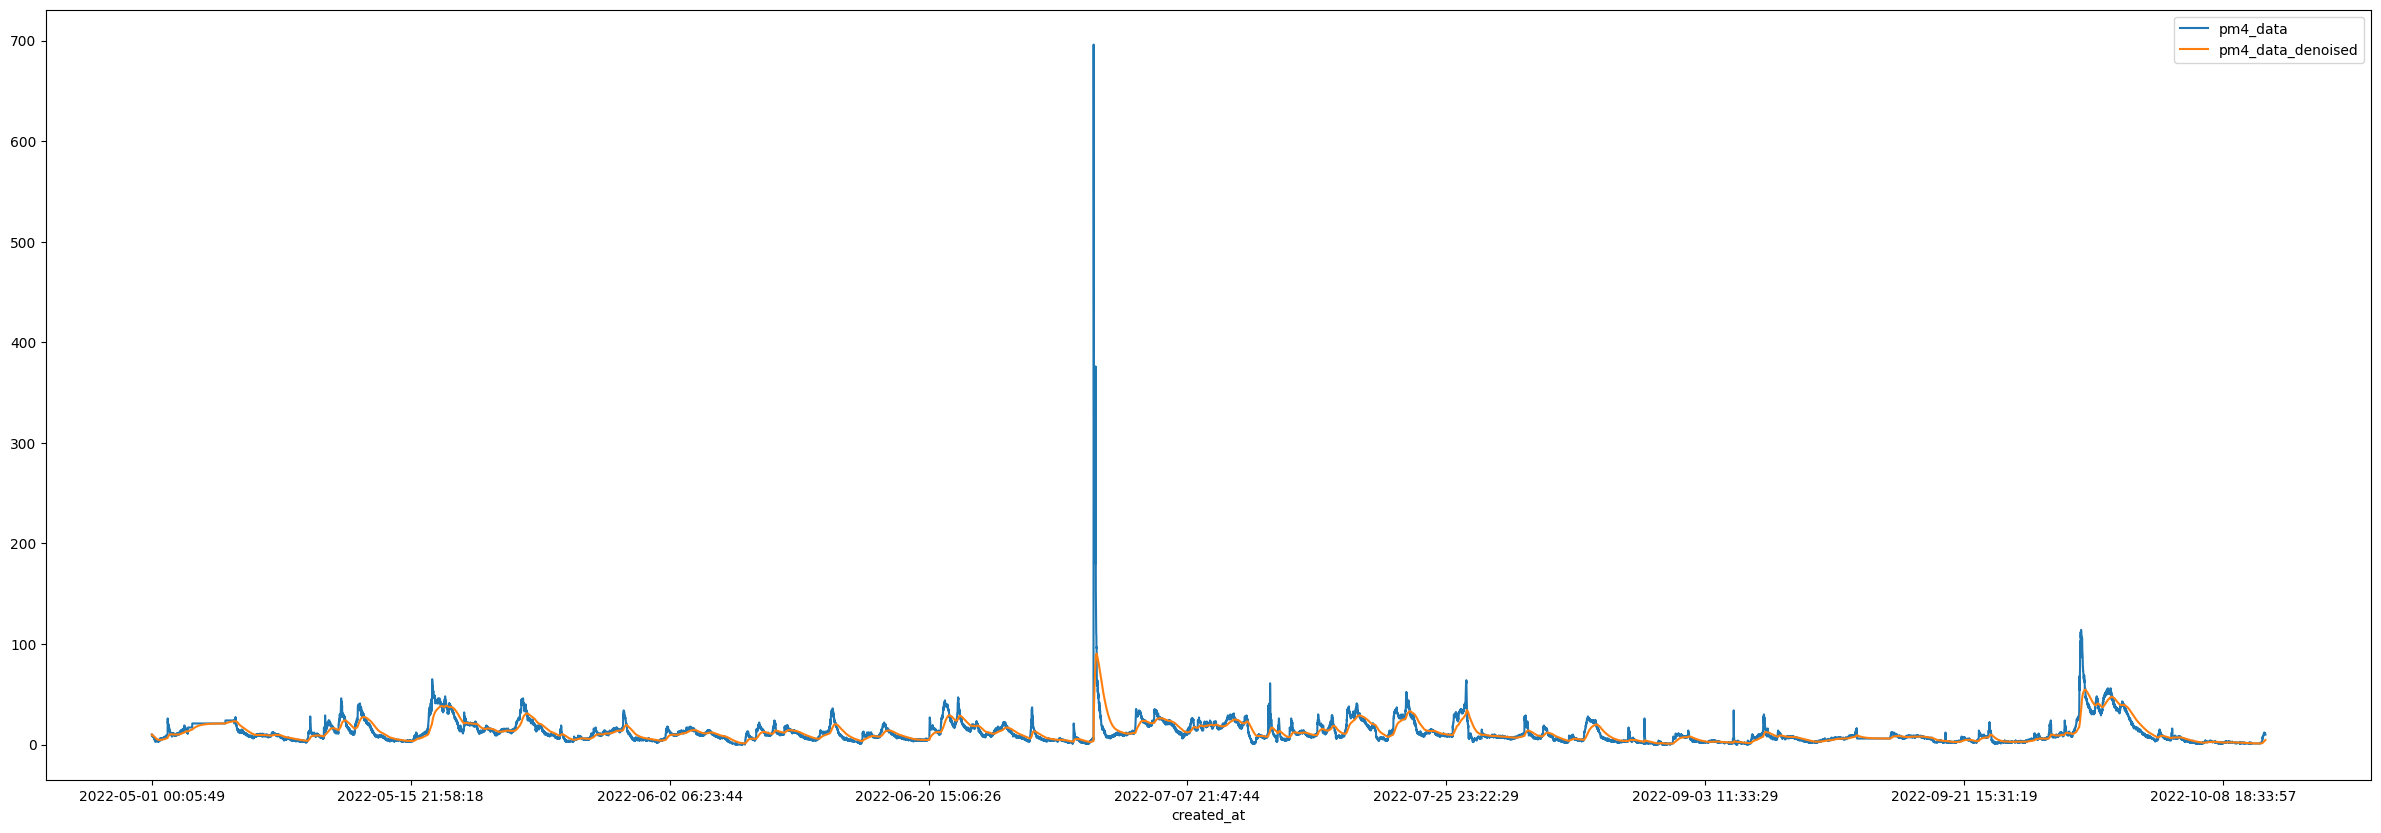

In [17]:
# pm 4.0 data
ema = pd.DataFrame(hr_sensor_data_value['pm4_data']).ewm(com).mean()
hr_sensor_data_value_denoised['pm4_data_denoised'] = ema['pm4_data']
hr_sensor_data_value_denoised.plot(y=['pm4_data', 'pm4_data_denoised'], figsize=(30,10))


<AxesSubplot:xlabel='created_at'>

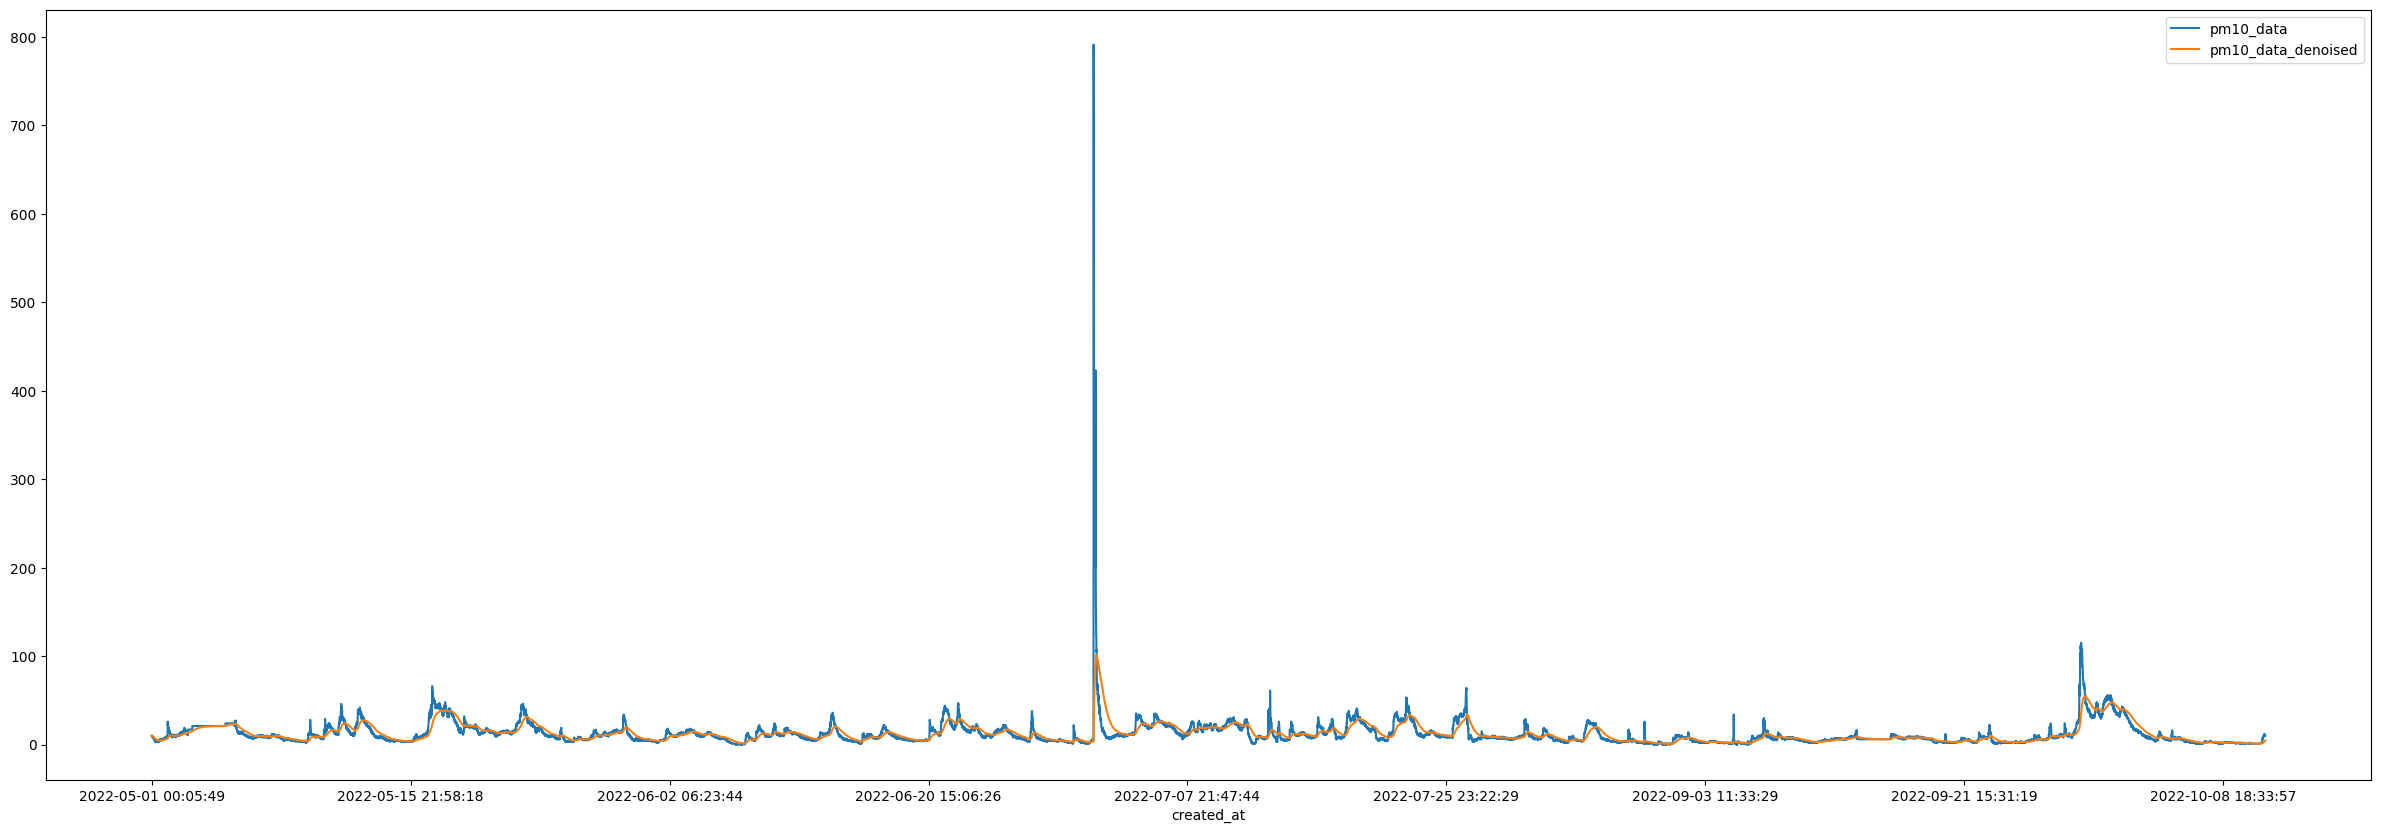

In [18]:
# pm 10.0 data
ema = pd.DataFrame(hr_sensor_data_value['pm10_data']).ewm(com).mean()
hr_sensor_data_value_denoised['pm10_data_denoised'] = ema['pm10_data']
hr_sensor_data_value_denoised.plot(y=['pm10_data', 'pm10_data_denoised'], figsize=(30,10))


In [20]:
print("pm 1.0 & pm 2.5: {}".format(pearsonr(hr_sensor_data_value['pm1_data_denoised'],hr_sensor_data_value['pm2_data_denoised'])[0]))
print("pm 1.0 & pm 4.0: {}".format(pearsonr(hr_sensor_data_value['pm1_data_denoised'],hr_sensor_data_value['pm4_data_denoised'])[0]))
print("pm 1.0 & pm 10.0: {}".format(pearsonr(hr_sensor_data_value['pm1_data_denoised'],hr_sensor_data_value['pm10_data_denoised'])[0]))
print("pm 2.5 & pm 4.0: {}".format(pearsonr(hr_sensor_data_value['pm2_data_denoised'],hr_sensor_data_value['pm4_data_denoised'])[0]))
print("pm 2.5 & pm 10.0: {}".format(pearsonr(hr_sensor_data_value['pm2_data_denoised'],hr_sensor_data_value['pm10_data_denoised'])[0]))
print("pm 4.0 & pm 10.0: {}".format(pearsonr(hr_sensor_data_value['pm4_data_denoised'],hr_sensor_data_value['pm10_data_denoised'])[0]))


pm 1.0 & pm 2.5: 0.9845064879643068
pm 1.0 & pm 4.0: 0.9554693967610117
pm 1.0 & pm 10.0: 0.9392621553054157
pm 2.5 & pm 4.0: 0.9924078521586841
pm 2.5 & pm 10.0: 0.9848872583510553
pm 4.0 & pm 10.0: 0.998710588030193


In [95]:
hr_sensor_data_t_h_value_denoised = hr_sensor_data_value_denoised[["temp_data_denoised","humid_data_denoised"]]
hr_sensor_data_t_h_value_denoised.index=hr_sensor_data["created_at"]
hr_sensor_data_t_h_value_denoised

,temp_data_denoised,humid_data_denoised
created_at,,
2022-05-01 00:05:49,27.500000,26.600000
2022-05-01 00:15:49,27.500000,26.549505
2022-05-01 00:25:49,27.533996,26.532675
2022-05-01 00:35:49,27.550990,26.498515
2022-05-01 00:45:49,27.561184,26.478024
...,...,...
2022-10-11 13:24:55,19.307848,55.387516
2022-10-11 13:34:55,19.309655,55.238741
2022-10-11 13:44:55,19.311426,55.141903


In [96]:
train = hr_sensor_data_t_h_value_denoised.iloc[:-2000,:]
test = hr_sensor_data_t_h_value_denoised.iloc[-2000:,:]

<AxesSubplot:xlabel='created_at'>

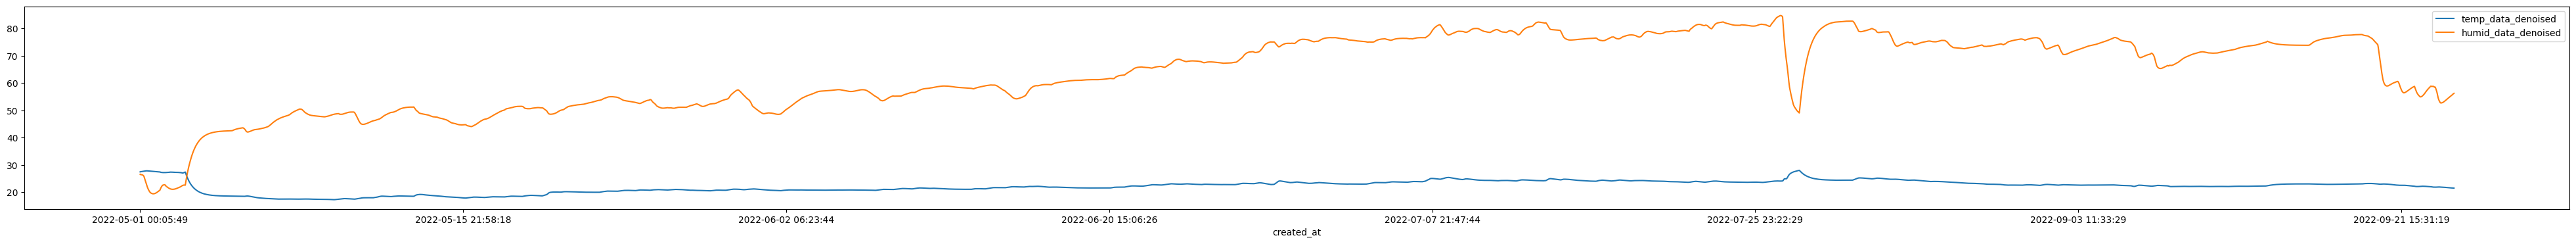

In [97]:
train.plot(figsize=(50,4))

In [99]:
forecasting_model = VAR(train)
results = forecasting_model.fit(2000)
results.summary()

/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 16, Oct, 2022
Time:                     18:18:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.9984
Nobs:                     12327.0    HQIC:                  -20.2013
Log likelihood:           107475.    FPE:                3.52460e-10
AIC:                     -21.8148    Det(Omega_mle):     2.00890e-10
--------------------------------------------------------------------
Results for equation temp_data_denoised
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.001078         0.000421            2.563           0.010
L1.temp_data_denoised             2.007808         0.011624          172.730           0.000

In [104]:
laaged_values = train.values[-2000:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=2000), index = test.index, columns= [['temp_data_denoised','humid_data_denoised']])
forecast

,temp_data_denoised,humid_data_denoised
created_at,,
2022-09-24 11:41:42,21.552244,56.239080
2022-09-24 11:51:42,21.547372,56.263630
2022-09-24 12:01:42,21.543099,56.291829
2022-09-24 12:11:42,21.538347,56.327081
2022-09-24 12:21:42,21.532807,56.353484
...,...,...
2022-10-11 13:24:55,20.968080,60.011330
2022-10-11 13:34:55,20.966222,60.035716
2022-10-11 13:44:55,20.964726,60.055030


/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/seohyun/Desktop/KHU/capstone2/code/python-data-control/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='created_at'>

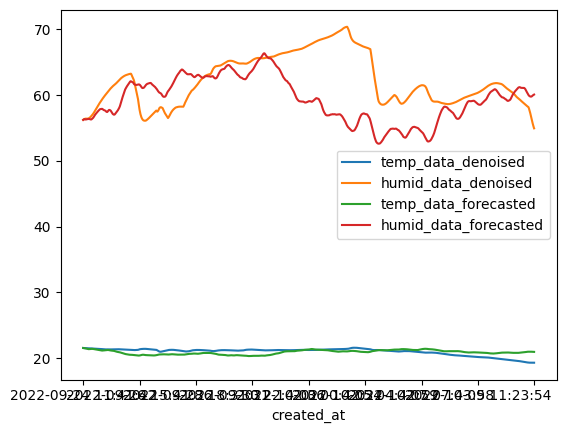

In [106]:
test["temp_data_forecasted"] = forecast["temp_data_denoised"]
test["humid_data_forecasted"] = forecast["humid_data_denoised"]
test.plot()

In [108]:
mean_squared_error(test["temp_data_forecasted"], test["temp_data_denoised"])

0.39968598154689905

In [110]:
mean_squared_error(test["humid_data_forecasted"], test["humid_data_denoised"])

30.79047880797936